In [1]:
import polars as pl
import re
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
def clean_text(text: str) -> str:
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    return text.lower().strip()

In [45]:
df = pl.read_parquet("data/projevy.parquet").filter(
    pl.col("komora_komplet").str.contains("Parlament České republiky, Pos") | pl.col("komora_komplet").str.contains("PČR, PS")
).with_columns(
    pl.col('text').str.len_bytes().alias('delka_projevu')
).filter(
    pl.col('delka_projevu') > 500
).sample(25000)

In [46]:
chamber_df = (
    df.filter(pl.col("komora_komplet").is_not_null())
    .with_columns(pl.col("text").map_elements(clean_text))
    .group_by("komora_komplet")
    .agg(pl.col("text").str.concat(" ").alias("chamber_text"))
    .drop_nulls()
)

C:\Users\micha\AppData\Local\Temp\ipykernel_2812\704011050.py:3: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns(pl.col("text").map_elements(clean_text))
C:\Users\micha\AppData\Local\Temp\ipykernel_2812\704011050.py:5: DeprecationWarning: `str.concat` is deprecated; use `str.join` instead. Note also that the default `delimiter` for `str.join` is an empty string, not a hyphen.
  .agg(pl.col("text").str.concat(" ").alias("chamber_text"))


In [47]:
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Generate embeddings
chamber_texts = chamber_df["chamber_text"].to_list()
chamber_embeddings = model.encode(chamber_texts)

# Add embeddings to DataFrame
chamber_df = chamber_df.with_columns(
    pl.Series(name="embedding", values=chamber_embeddings.tolist())
)


In [48]:
import numpy as np

In [49]:
emb_matrix = np.array(chamber_df["embedding"].to_list())

# Reduce dimensionality with PCA
pca = PCA(n_components=2)
reduced_emb = pca.fit_transform(emb_matrix)

# Add to DataFrame
chamber_df = chamber_df.with_columns(
    pl.Series(name="x", values=reduced_emb[:, 0]),
    pl.Series(name="y", values=reduced_emb[:, 1])
)

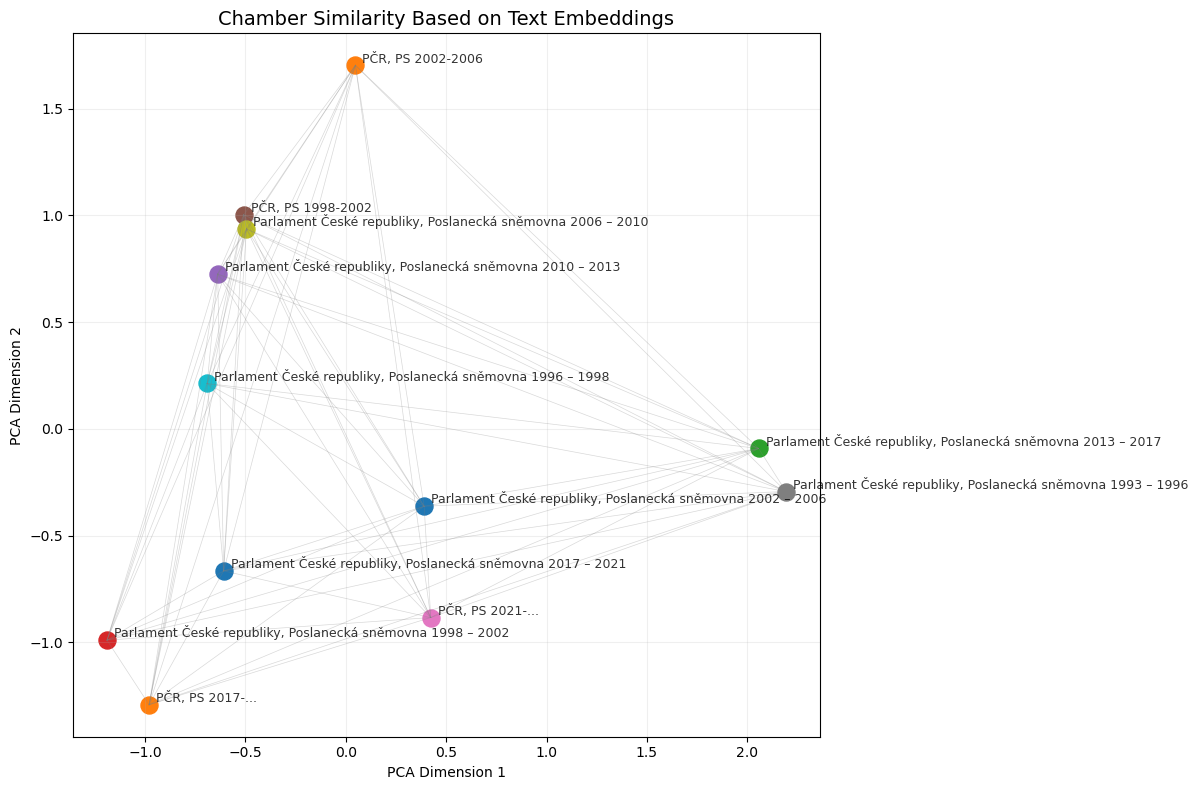

In [50]:
plt.figure(figsize=(12, 8))
ax = plt.subplot()

# Plot each chamber
for row in chamber_df.iter_rows(named=True):
    ax.scatter(row["x"], row["y"], s=150)
    ax.annotate(
        row["komora_komplet"], 
        (row["x"], row["y"]),
        xytext=(5, 2),
        textcoords='offset points',
        fontsize=9,
        alpha=0.8
    )

# Add plot decorations
plt.title("Chamber Similarity Based on Text Embeddings", fontsize=14)
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid(alpha=0.2)
plt.tight_layout()

# Add distance indicators (optional)
for i in range(len(reduced_emb)):
    for j in range(i+1, len(reduced_emb)):
        plt.plot(
            [reduced_emb[i,0], reduced_emb[j,0]],
            [reduced_emb[i,1], reduced_emb[j,1]],
            'gray', 
            linewidth=0.5, 
            alpha=0.3
        )

plt.show()